In [1]:
import xarray as xr
# import cfgrib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import numpy as np
from plot_picture_function import set_map_ticks,add_Chinese_provinces
from datetime import timedelta
import cartopy.crs as ccrs

In [2]:
#读取merra2数据
filepath = r'E:\ZiYuanPingGu\MERRA2_0.5\MERRA2_400.inst1_2d_asm_Nx.20200115.SUB.nc'#储存路径
dayinst = 15
hour = 6
ds1 = xr.open_dataset(filepath)#打开文件
ds1#展示数据

<xarray.Dataset>
Dimensions:  (time: 24, lon: 89, lat: 81)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-15 ... 2020-01-15T23:00:00
  * lon      (lon) float64 80.0 80.62 81.25 81.88 ... 133.1 133.8 134.4 135.0
  * lat      (lat) float64 15.0 15.5 16.0 16.5 17.0 ... 53.0 53.5 54.0 54.5 55.0
Data variables:
    TQI      (time, lat, lon) float32 ...
    TQL      (time, lat, lon) float32 ...
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    Conventions:                       CF-1
    History:                           Original file generated: Sat Jan 25 21...
    Comment:                           GMAO filename: d5124_m2_jan10.inst1_2d...
    Filename:                          MERRA2_400.inst1_2d_asm_Nx.20200115.nc4
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    RangeBeginningDate:                2020-01-15
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2020-01-15
    RangeEndingTime:                   23:00:00.000000
    history_L34RS:                     'Created by L34RS v1.4.2 @ NASA GES DI...
    CDO:                               Climate Data Operators version 1.9.8 (...

In [3]:
#预设待储存的merra2数据集，目的是与其他数据集的大小一致，merra2分辨率为0.5×0.625，插值为0.5×0.5
interp_MERRA2 = xr.Dataset({
    'TQI':(('time', 'lat', 'lon'), np.zeros([24, 81, 111])),
    'TQL':(('time', 'lat', 'lon'), np.zeros([24, 81, 111])),
    'time':(('time'), ds1.time.values),
    'lon':(('lon'),np.linspace(80,135,111)),
    'lat':(('lat'),np.linspace(55,15,81))
})
interp_MERRA2

<xarray.Dataset>
Dimensions:  (time: 24, lat: 81, lon: 111)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-15 ... 2020-01-15T23:00:00
  * lon      (lon) float64 80.0 80.5 81.0 81.5 82.0 ... 133.5 134.0 134.5 135.0
  * lat      (lat) float64 55.0 54.5 54.0 53.5 53.0 ... 17.0 16.5 16.0 15.5 15.0
Data variables:
    TQI      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TQL      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [4]:
ds1.lon.values[0::4].shape, ds1.lon.values[0::4]

((23,),
 array([ 80. ,  82.5,  85. ,  87.5,  90. ,  92.5,  95. ,  97.5, 100. ,
        102.5, 105. , 107.5, 110. , 112.5, 115. , 117.5, 120. , 122.5,
        125. , 127.5, 130. , 132.5, 135. ]))

In [5]:
#插值处理，由于只需要经度进行插值，插值思想：纬度不变，只对经度插值。0.625四个为一周期，0.5五个为一周期
interp_MERRA2.TQL.data[:,:,::5] = ds1.TQL.values[:,:,::4]
interp_MERRA2.TQI.data[:,:,::5] = ds1.TQI.values[:,:,::4]
for i in np.arange(1,5):
    a = (interp_MERRA2.lon.values[i]-ds1.lon.values[i-1])/0.625  #插值系数
    interp_MERRA2.TQI.data[:,:,i:-1:5] = ds1.TQI.values[:,:,i-1:-1:4] + a*(ds1.TQI.values[:,:,i::4]-ds1.TQI.values[:,:,i-1:-1:4])
    interp_MERRA2.TQL.data[:,:,i:-1:5] = ds1.TQL.values[:,:,i-1:-1:4] + a*(ds1.TQL.values[:,:,i::4]-ds1.TQL.values[:,:,i-1:-1:4])
    print(a)

0.8
0.6
0.4
0.2


In [6]:
      
x = interp_MERRA2.lat#提取维度
y = interp_MERRA2.lon#提取经度
X_MERRA2, Y_MERRA2 = np.meshgrid(y, x)#一维合成二维，返回二维坐标矩阵

thresh = 0#阈值，后面用作数据白化，低于此值将赋为np.nan

MERRA2_CHN_cw = interp_MERRA2.TQL.data[hour,:,:]#[time, lat, lon]
MERRA2_CHN_ci = interp_MERRA2.TQI.data[hour,:,:]

MERRA2_CHN_cw[MERRA2_CHN_cw < thresh] = np.nan
MERRA2_CHN_ci[MERRA2_CHN_ci < thresh] = np.nan

In [7]:
#读取JRA55文件
dataJRA55_cw = xr.open_dataset(r'E:\ZiYuanPingGu\JRA55\cloud\fcst_column125.227_cw.2020010100_2020013121.xue558691.nc')#读取ERA5 20200101整日数据
dataJRA55_ci = xr.open_dataset(r'E:\ZiYuanPingGu\JRA55\cloud\fcst_column125.058_cice.2020010100_2020013121.xue558691.nc')

In [8]:
JRA55_daysindex = round((dayinst-1)*4+hour/6+1)
dataJRA55_cw.initial_time0_hours[JRA55_daysindex]

<xarray.DataArray 'initial_time0_hours' ()>
array('2020-01-15T06:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    initial_time0_hours  datetime64[ns] 2020-01-15T06:00:00
Attributes:
    long_name:  initial time

In [9]:
JRA55_world_cw = dataJRA55_cw.CW_GDS0_EATM[JRA55_daysindex, 1, :, :]#[time, lat, lon]，JRA55一天4个数据，间隔6小时
JRA55_world_ci = dataJRA55_ci.CICE_GDS0_EATM[JRA55_daysindex, 1, :, :]#[time, lat, lon]

In [10]:
x = np.linspace(55,15,round((55-15)/1.25+1))#自建纬度坐标，55->15，间隔1.25
y = np.linspace(80,135,round((135-80)/1.25+1))#自建经度坐标，80->135，间隔1.25
X_JRA55, Y_JRA55 = np.meshgrid(y, x)

In [11]:
lat_s = np.where(dataJRA55_cw.g0_lat_2 == 15)[0][0]#找到维度等于15的数据索引(位置)
lat_n = np.where(dataJRA55_cw.g0_lat_2 == 55)[0][0]
lon_w = np.where(dataJRA55_cw.g0_lon_3 == 80)[0][0]
lon_e = np.where(dataJRA55_cw.g0_lon_3 == 135)[0][0]

JRA55_CHN_cw = JRA55_world_cw[lat_n:lat_s+1, lon_w:lon_e+1].values#提取云水数据
JRA55_CHN_cw[JRA55_CHN_cw < thresh] = np.nan
JRA55_CHN_ci = JRA55_world_ci[lat_n:lat_s+1, lon_w:lon_e+1].values#提取云冰数据
JRA55_CHN_ci[JRA55_CHN_ci < thresh] = np.nan

In [12]:
#读取ERA5数据
dataERA5 = xr.open_dataset('E:/ZiYuanPingGu/ERA5/01.nc')
dataERA5

<xarray.Dataset>
Dimensions:    (longitude: 221, latitude: 161, time: 744)
Coordinates:
  * longitude  (longitude) float32 80.0 80.25 80.5 80.75 ... 134.5 134.8 135.0
  * latitude   (latitude) float32 55.0 54.75 54.5 54.25 ... 15.5 15.25 15.0
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-01-31T23:00:00
Data variables:
    tciw       (time, latitude, longitude) float32 ...
    tclw       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-03-20 02:56:22 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

In [13]:
dataERA5.time[(dayinst-1)*24+hour]#[time, lat, lon]，ERA5数据时间间隔1h,一天有24个数据

<xarray.DataArray 'time' ()>
array('2020-01-15T06:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-15T06:00:00
Attributes:
    long_name:  time

In [14]:
ERA5_CHN_cw = dataERA5.tclw.values[(dayinst-1)*24+hour,:,:]
ERA5_CHN_cw[ERA5_CHN_cw < thresh] = np.nan
ERA5_CHN_ci = dataERA5.tciw.values[(dayinst-1)*24+hour,:,:]
ERA5_CHN_ci[ERA5_CHN_ci < thresh] = np.nan

## 需自己修改H8文件路径

In [15]:
dataH8 = xr.open_dataset(r'E:\ZiYuanPingGu\hiwimari8_data\hiwamari\2020\202001\15\06\NC_H08_20200115_0600_L2CLP010_FLDK.02401_02401.nc')
#读取himawari-8文件数据
dataH8

<xarray.Dataset>
Dimensions:    (latitude: 2401, longitude: 2401)
Coordinates:
  * latitude   (latitude) float32 60.0 59.95 59.9 59.85 ... -59.9 -59.95 -60.0
  * longitude  (longitude) float32 80.0 80.05 80.1 80.15 ... 199.9 200.0 200.0
Data variables:
    Hour       (latitude, longitude) timedelta64[ns] ...
    CLOT       (latitude, longitude) float32 ...
    CLTT       (latitude, longitude) float32 ...
    CLTH       (latitude, longitude) float32 ...
    CLER_23    (latitude, longitude) float32 ...
    CLTYPE     (latitude, longitude) float32 ...
    QA         (latitude, longitude) float32 ...
Attributes: (12/16)
    title:                 Himawari-8 AHI equal latitude-longitude map data -...
    summary:               N/A
    keywords:              Himawari8
    id:                    NC_H08_20200115_0600_R21CLPR_FLDK.02401_02401.nc
    comment:               N/A
    date_created:          20200115 07:51:08.000
    ...                    ...
    project:               N/A
    pixel_number:          2401
    line_number:           2401
    upper_left_latitude:   60.0
    upper_left_longitude:  80.0
    grid_interval:         0.05

In [16]:
binary_repr_v = np.vectorize(np.binary_repr)#numpy的数据向量操作，可以看作快速对矩阵中单个数据做二进制的转换操作

qa = dataH8.QA#H8的QA数据，对数据做质量评价
qa_int = qa.data#提取数据
qa_int = qa_int.astype(np.int)#转为int型数据
qa_bin = binary_repr_v(qa_int, 16)#转为16位的二进制数据
qa65 = np.array([qa_bin[i][j][9:11] for i in range(len(qa_bin)) for j in range(len(qa_bin))])
#切片操作，提取分辨云水、冰的片段
qa65 = qa65.reshape(2401,2401)#将矩阵变为2401×2401
qa_wc = np.zeros([2401, 2401])*np.nan#水云数据矩阵初始化
qa_ic = np.zeros([2401, 2401])*np.nan#冰云数据矩阵初始化
qa_mix = np.zeros([2401, 2401])*np.nan#混合云，后面并未使用
qa_wc[qa65 == '01'] = 1#得到1-0的整数矩阵
qa_mix[qa65 == '10'] = 1
qa_ic[qa65 == '11'] = 1


C:\Users\dell\AppData\Local\Temp\ipykernel_29804\2912877295.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  qa_int = qa_int.astype(np.int)#转为int型数据


In [17]:
x = dataH8.longitude#经度
y = dataH8.latitude#维度
ct = dataH8.CLOT#云光学厚度
cr = dataH8.CLER_23#云粒子有效半径
clt = dataH8.CLTT

#查找出经度80E-135E对应的索引，维度15N-55N对应的索引
lon_w = 0
lon_e = 0
lat_n = 0
lat_s = 0

lon_w = np.where(ct.longitude.values == 80)[0][0]
lon_e = np.where(ct.longitude.values == 135)[0][0]

lat_n = np.where(ct.latitude.values == 55)[0][0]
lat_s = np.where(ct.latitude.values == 15)[0][0]
step = 5#步进

x_cut = x[lon_w:lon_e+1:step]
y_cut = y[lat_n:lat_s+1:step]
X_cut, Y_cut = np.meshgrid(x_cut, y_cut)
   
ct.values[ct.values < -327] = np.nan
cr.values[cr.values < -327] = np.nan

lwp_p = ct * cr * 5/9 * 0.001#单位，不乘0.001就是g/m^2
lwp_qa = qa_wc * lwp_p.values#np.ndarray不支持二维bool索引
lwp_qa[lwp_qa < thresh] = np.nan
lwp_ori = lwp_qa.copy()
lwp_qa[clt.data < 268] = np.NaN

lwp_mix = qa_mix * lwp_p #混合云的云水，后面并未使用

iwp_p = ct**(1/0.84)/0.065 * 0.001
iwp_qa = qa_ic * iwp_p.values
iwp_qa[iwp_qa < thresh] = np.nan
iwp_ori = iwp_qa.copy()
iwp_qa[clt.data < 268] = np.NaN

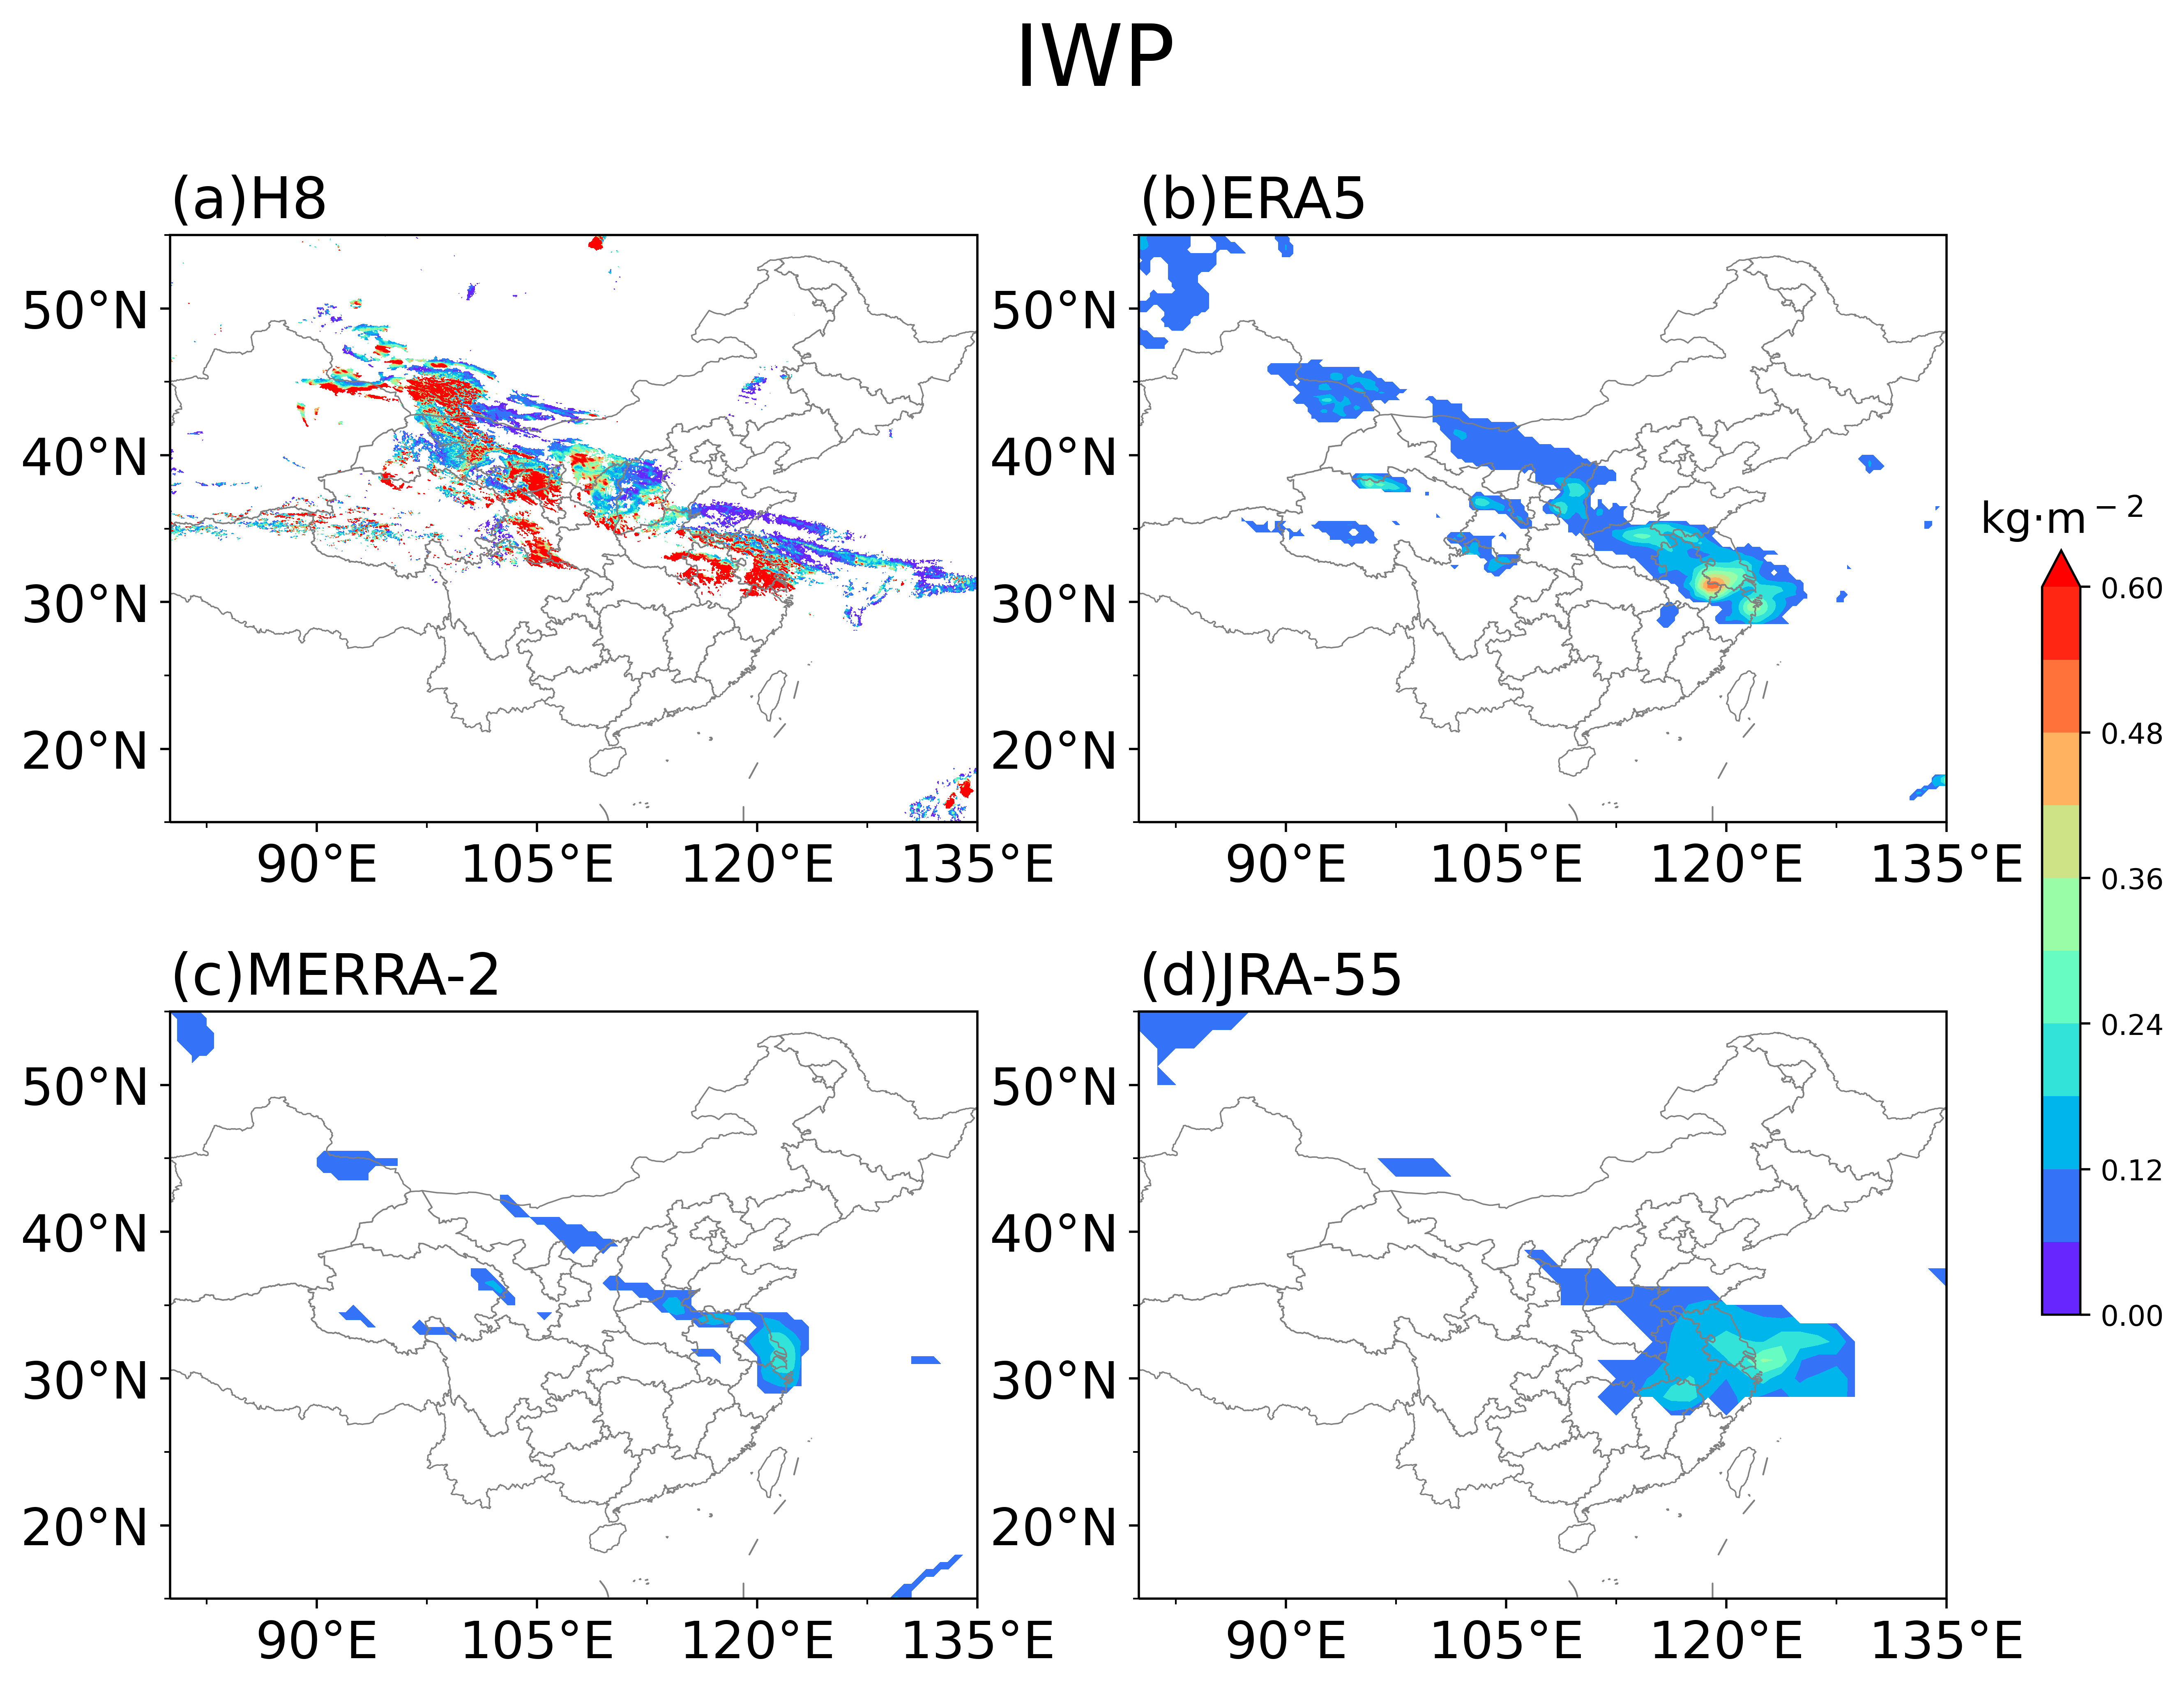

In [31]:
plt.close()
plot_pic(iwp_CHN_ori, ERA5_CHN_ci, MERRA2_CHN_ci, JRA55_CHN_ci)

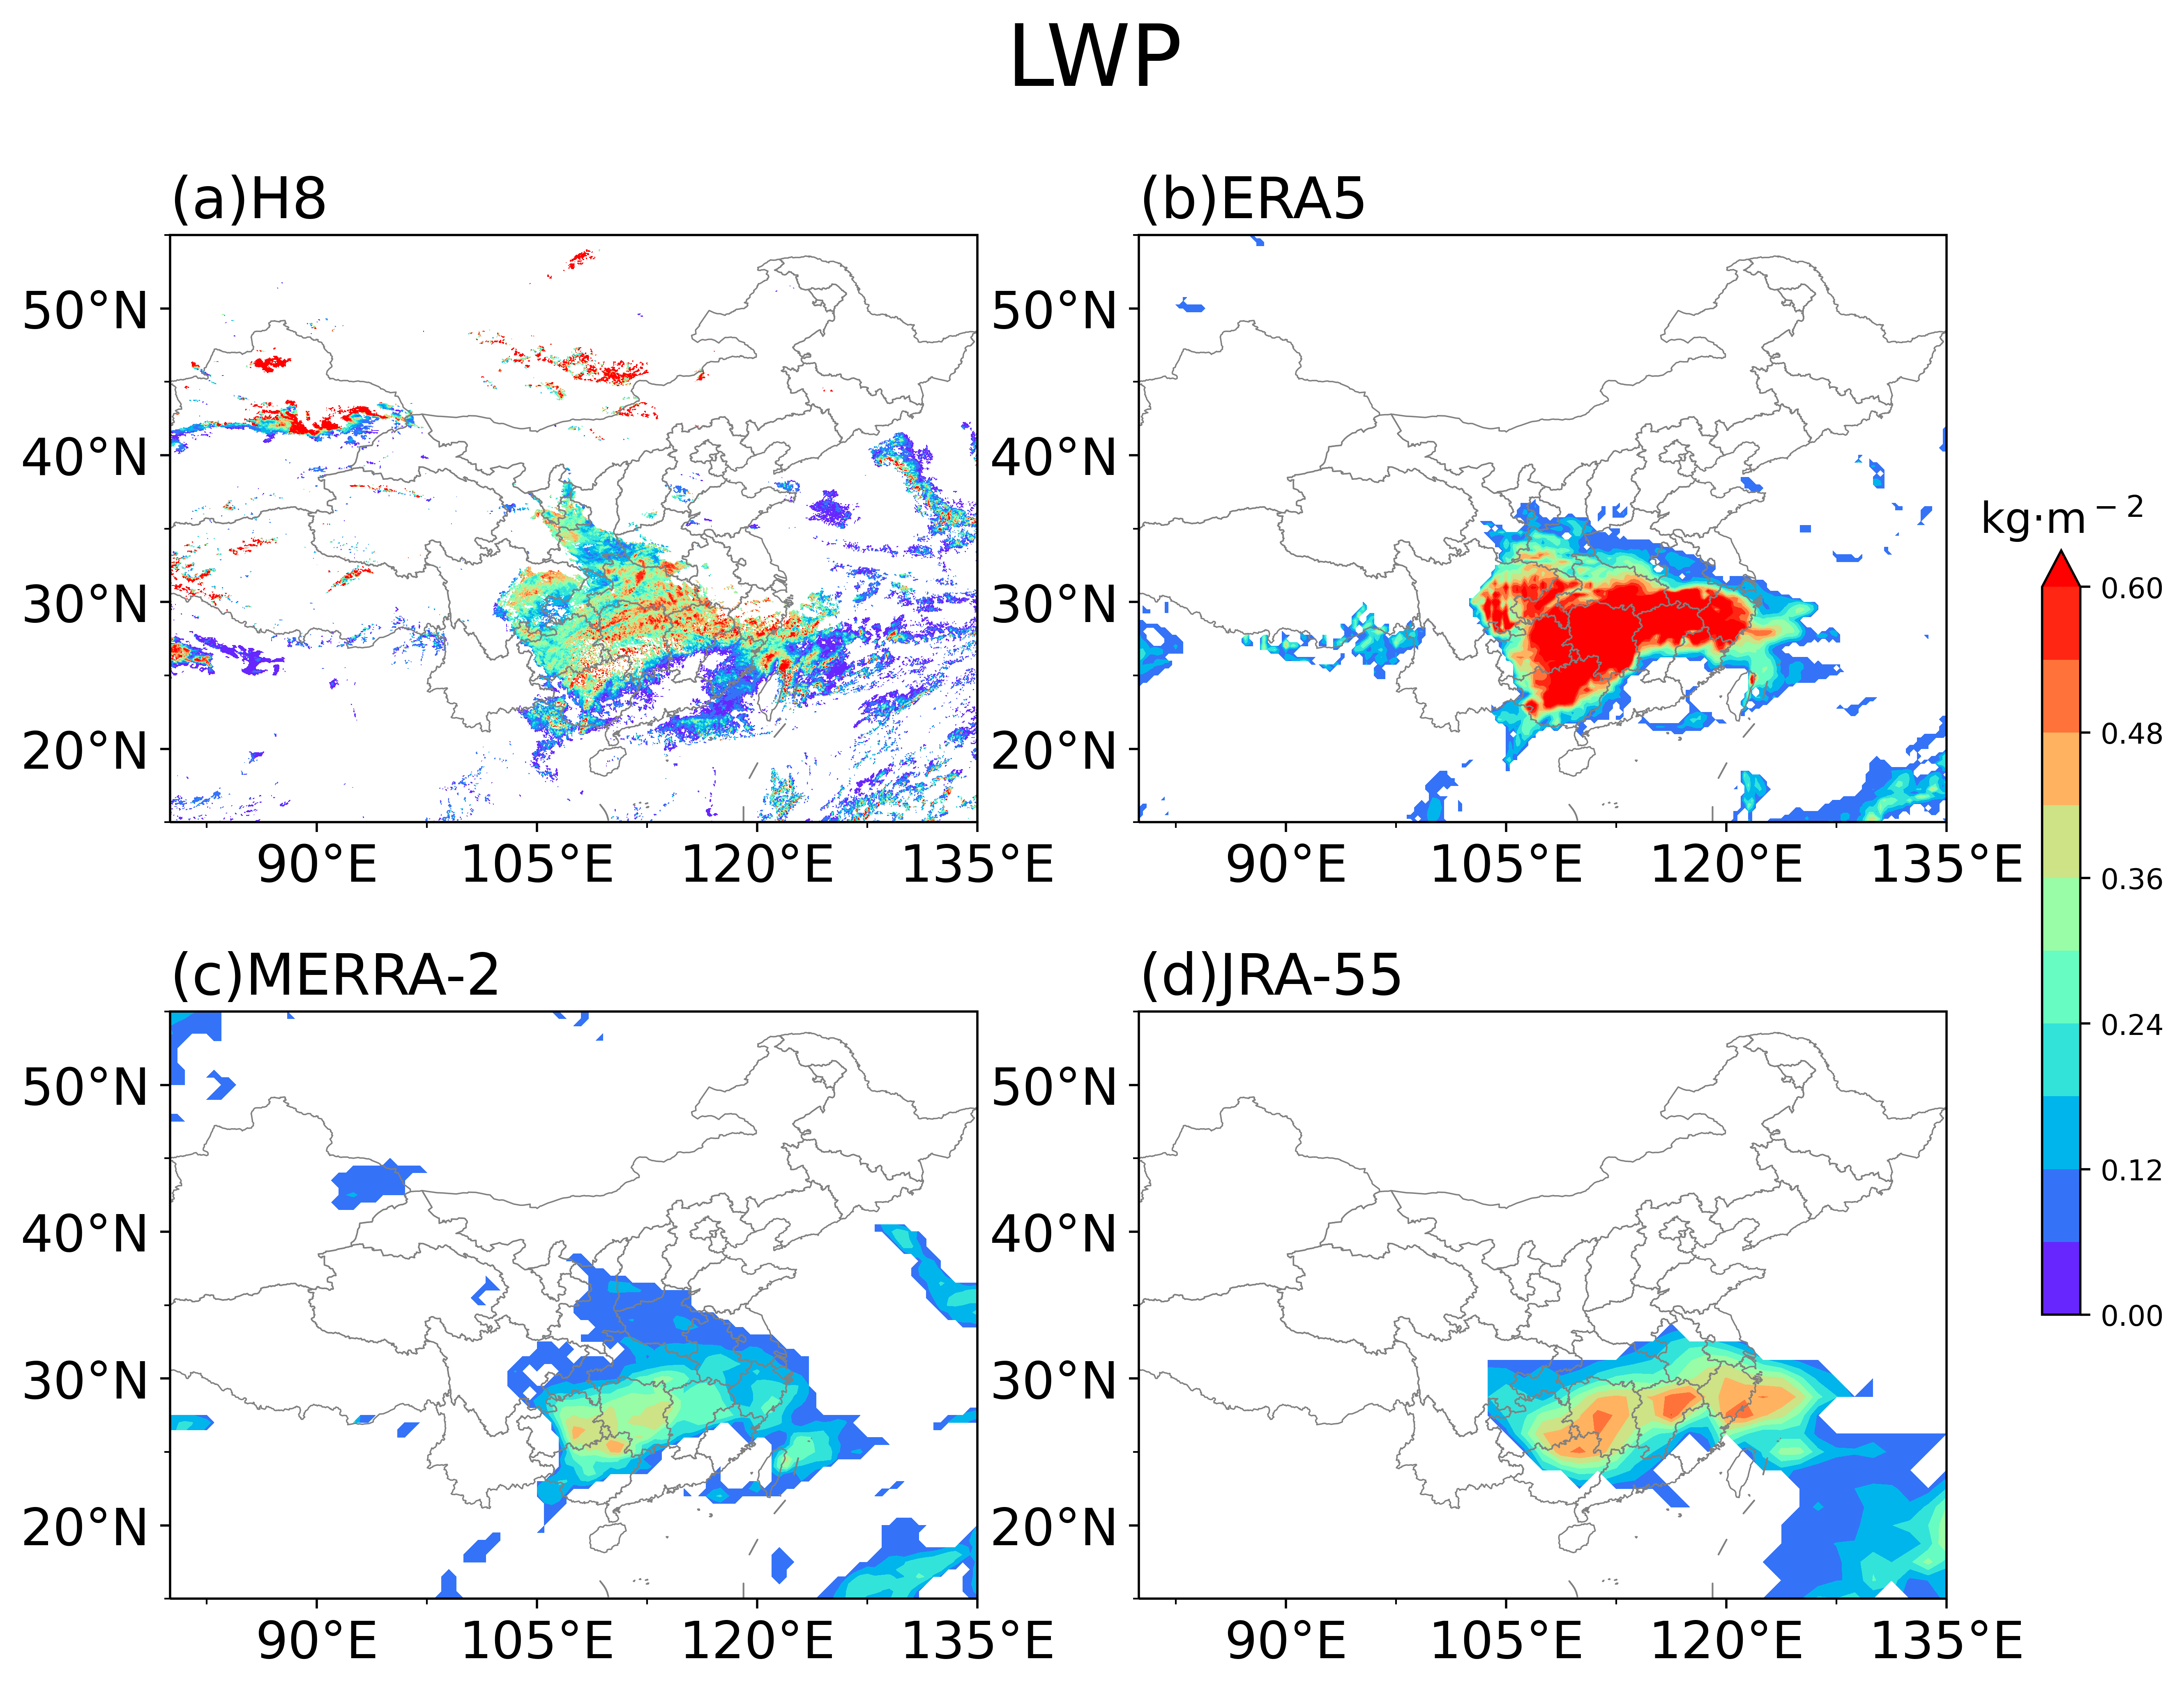

In [29]:
plt.close()
plot_pic(lwp_CHN_ori, ERA5_CHN_cw, MERRA2_CHN_cw, JRA55_CHN_cw)

In [30]:
def plot_pic(dataset1, dataset2, dataset3, dataset4):#画图
    dataset2 = dataset2.copy()
    dataset2[dataset2 < 0.06] = np.nan
    dataset3 = dataset3.copy()
    dataset3[dataset3 < 0.06] = np.nan
    dataset4 = dataset4.copy()
    dataset4[dataset4 < 0.06] = np.nan
    extent = [80, 135, 15, 55]
    levels = np.linspace(0, 0.6, 11)
    proj = ccrs.PlateCarree()#选择投影方式，平面投影
    axs = []

    fig = plt.figure(figsize=(12,9), dpi=500)
    ax1 = fig.add_subplot(221, projection=proj)#创建一个轴，或者是说主体
    ax1.set_title('(a)H8', fontsize=20, loc='left')
    
    im1 = ax1.contourf(x_ori, y_ori, dataset1, levels=levels, cmap='rainbow', extend='max')
    add_Chinese_provinces(ax1, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    set_map_ticks(ax1, dx=15, dy=10, nx=1, ny=1, labelsize=18)#自定义函数set_map_tick
    ax1.set_extent(extent, crs=proj)

    ax2 = fig.add_subplot(222, projection=proj)#创建一个轴，或者是说主体
    # 设置经纬度刻度.
    set_map_ticks(ax2, dx=15, dy=10, nx=1, ny=1, labelsize=18)#自定义函数set_map_tick
    ax2.set_title('(b)ERA5', fontsize=20, loc='left')

    im2 = ax2.contourf(X_cut, Y_cut, dataset2, levels=levels, cmap = 'rainbow', extend='max')
    add_Chinese_provinces(ax2, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    ax2.set_extent(extent, crs=proj)
    #设置colorbar的位置
    # cax2 = fig.add_axes([ax2.get_position().x1 + 0.01, ax2.get_position().y0, 0.02, ax2.get_position().height])
    # plt.colorbar(im2, cax=cax2, label='kg·m$^-$$^2$')
    
    ax3 = fig.add_subplot(223, projection=proj)#创建一个轴，或者是说主体
    # 设置经纬度刻度.
    set_map_ticks(ax3, dx=15, dy=10, nx=1, ny=1, labelsize=18)#自定义函数set_map_tick
    ax3.set_title('(c)MERRA-2', fontsize=20, loc='left')
    im3 = ax3.contourf(X_MERRA2, Y_MERRA2, dataset3[::-1,:], levels=levels, cmap = 'rainbow', extend='max')
    add_Chinese_provinces(ax3, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    ax3.set_extent(extent, crs=proj)
    
    ax4 = fig.add_subplot(224, projection=proj)#创建一个轴，或者是说主体
    # 设置经纬度刻度.
    set_map_ticks(ax4, dx=15, dy=10, nx=1, ny=1, labelsize=18)#自定义函数set_map_tick

    ax4.set_title('(d)JRA-55', fontsize=20, loc='left')

    im4 = ax4.contourf(X_JRA55, Y_JRA55, dataset4, levels=levels, cmap = 'rainbow', extend='max')
    add_Chinese_provinces(ax4, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    ax4.set_extent(extent, crs=proj)
    #设置colorbar的位置
    # cax4 = fig.add_axes([ax4.get_position().x1 + 0.01, ax4.get_position().y0, 0.02, ax4.get_position().height])
#     cax5 = fig.add_axes([ax4.get_position().x1 + 0.03, ax4.get_position().y1+0.01, 0.04, 0.03])
#     cax5.text(0,0.1,'kg·m$^-$$^2$')
#     cax5.spines['top'].set_visible(False)
#     cax5.spines['bottom'].set_visible(False)
#     cax5.spines['left'].set_visible(False)
#     cax5.spines['right'].set_visible(False)
#     cax5.set_xticks([])
#     cax5.set_yticks([])
    axs = [ax1, ax2, ax3, ax4]
    cb = plt.colorbar(im1, ax=axs, fraction=0.02, pad=0.05)
    cb.ax.set_title('kg·m$^-$$^2$', fontsize=15)
    # plt.colorbar(im4, cax=cax4, label='kg·m$^-$$^2$')
    plt.suptitle('IWP',fontsize=30)


In [ ]:
def plot_pic2(dataset1, dataset2, dataset3, dataset4):#画图
    extent = [80, 135, 15, 55]
    levels = np.linspace(0, 0.6, 11)
    proj = ccrs.PlateCarree()#选择投影方式，平面投影
    
    fig = plt.figure(figsize=(12,9), dpi=500)
    ax1 = fig.add_subplot(221, projection=proj)#创建一个轴，或者是说主体
    ax1.set_title('(a)H8', fontsize=15, loc='left')
    
    im1 = ax1.contourf(x_ori, y_ori, dataset1, levels=levels, cmap='rainbow', extend='max')
    add_Chinese_provinces(ax1, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    set_map_ticks(ax1, dx=10, dy=10, nx=1, ny=1, labelsize=15)#自定义函数set_map_tick
    ax1.set_extent(extent, crs=proj)

    ax2 = fig.add_subplot(222, projection=proj)#创建一个轴，或者是说主体
    # 设置经纬度刻度.
    set_map_ticks(ax2, dx=10, dy=10, nx=1, ny=1, labelsize=15)#自定义函数set_map_tick
    ax2.set_title('(b)as_ERA5', fontsize=15, loc='left')

    im2 = ax2.contourf(X_cut, Y_cut, dataset2, levels=levels, cmap = 'rainbow', extend='max')
    add_Chinese_provinces(ax2, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    ax2.set_extent(extent, crs=proj)
    #设置colorbar的位置
    cax2 = fig.add_axes([ax2.get_position().x1 + 0.01, ax2.get_position().y0, 0.02, ax2.get_position().height])
    plt.colorbar(im2, cax=cax2, label='kg·m$^-$$^2$')
    
    ax3 = fig.add_subplot(223, projection=proj)#创建一个轴，或者是说主体
    # 设置经纬度刻度.
    set_map_ticks(ax3, dx=10, dy=10, nx=1, ny=1, labelsize=15)#自定义函数set_map_tick
    ax3.set_title('(c)as_JRA55', fontsize=15, loc='left')
    im3 = ax3.contourf(X_JRA55, Y_JRA55, dataset3, levels=levels, cmap = 'rainbow', extend='max')
    add_Chinese_provinces(ax3, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    ax3.set_extent(extent, crs=proj)
    
    ax4 = fig.add_subplot(224, projection=proj)#创建一个轴，或者是说主体
    # 设置经纬度刻度.
    set_map_ticks(ax4, dx=10, dy=10, nx=1, ny=1, labelsize=15)#自定义函数set_map_tick

    ax4.set_title('(d)as_MERRA2', fontsize=15, loc='left')

    im4 = ax4.contourf(X_MERRA2, Y_MERRA2, dataset4[::-1,:], levels=levels, cmap = 'rainbow', extend='max')
    add_Chinese_provinces(ax4, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    ax4.set_extent(extent, crs=proj)
    #设置colorbar的位置
    cax4 = fig.add_axes([ax4.get_position().x1 + 0.01, ax4.get_position().y0, 0.02, ax4.get_position().height])
#     cax5 = fig.add_axes([ax4.get_position().x1 + 0.03, ax4.get_position().y1+0.01, 0.04, 0.03])
#     cax5.text(0,0.1,'kg·m$^-$$^2$')
#     cax5.spines['top'].set_visible(False)
#     cax5.spines['bottom'].set_visible(False)
#     cax5.spines['left'].set_visible(False)
#     cax5.spines['right'].set_visible(False)
#     cax5.set_xticks([])
#     cax5.set_yticks([])
    plt.colorbar(im4, cax=cax4, label='kg·m$^-$$^2$')

In [20]:
#取中国地区的H8数据
lwp_CHN = lwp_qa[lat_n:lat_s+1,lon_w:lon_e+1]
lwp_CHN_ori = lwp_ori[lat_n:lat_s+1,lon_w:lon_e+1]
iwp_CHN_ori = iwp_ori[lat_n:lat_s+1,lon_w:lon_e+1]
x_ori = x[lon_w:lon_e+1]
y_ori = y[lat_n:lat_s+1]

In [21]:
print(lwp_CHN_ori.shape, ERA5_CHN_cw.shape, JRA55_CHN_cw.shape, MERRA2_CHN_cw.shape)

(801, 1101) (161, 221) (33, 45) (81, 111)


In [ ]:
# 自定义函数：将H8的数据按分辨率的大小分别对应再分析的格点，输出处理后的H8的格点数据结果。
def Get_H8lonlatindex(inputlon, inputlat):#获取80-135E，55-15N范围内对应的索引
    outputlon = round((inputlon - 80)/0.05)
    outputlat = round(-(inputlat - 60)/0.05)
    return outputlon, outputlat
def transformH8(data1, data2, resolution1, resolution2):#data1是局部数据，data2为全域数据，避免单独处理边缘格点
    num = round((resolution1/resolution2 - 1) / 2)#匹配方框区域格点半边长
    trans_array = np.ones(data1.shape)*(-1)
    
    treshold_u = round((resolution1/resolution2 - 1)**2*0.8)#一般情况下的阈值个数（90%的条件）
    
    dim_array = np.array([np.arange(0, 2*num+1) for i in range(2*num+1)])
    dimT_array = dim_array.T
    alpha_array = abs(dim_array-(num)) + abs(dimT_array-(num))
    max_dist = np.max(alpha_array)
    total_num = np.sum(max_dist - alpha_array)
    belta_array = (max_dist - alpha_array)/total_num
    print(belta_array)
    for i in range(data1.shape[0]):
        for j in range(data1.shape[1]):
            lon = 80 + j*resolution1
            lat = 55 - i*resolution1
#             print('lon:{0}, lat:{1}'.format(lon, lat))
            H8_lonindex, H8_latindex = Get_H8lonlatindex(lon, lat)
            if j == 0:
                temp_array = data2[H8_latindex-num:H8_latindex+num+1, H8_lonindex:H8_lonindex+num+1]
                datanum = len(temp_array.flatten())
                treshold = round(datanum * 0.8)
                if np.sum(~np.isnan(temp_array)) >= treshold:
                    trans_array[i, j] = np.mean(temp_array[~np.isnan(temp_array)])
#             if j == data2.shape[1]-1:
#                 temp_array = data2[H8_lat-num:H8_lat+num+1, H8_lonindex-num:H8_lonindex+1]
#                 datanum = len(temp_array.flatten())
#                 treshold = round(datanum * 0.9)
#                 if np.sum(~np.isnan(temp_array)) >= treshold:
#                     trans_array[i, j] = np.mean(temp_array[~np.isnan(temp_array)])
            else:
                temp_array = data2[H8_latindex-num:H8_latindex+num+1, H8_lonindex-num:H8_lonindex+num+1] * belta_array
                datanum = len(temp_array.flatten())
#                 print('how many:', np.sum(~np.isnan(temp_array)))
#                 print('treshold:', treshold_u)
#                 print('datanum:', datanum)
#                 print('num:', num)
                if np.sum(~np.isnan(temp_array)) >= treshold_u:
                    trans_array[i, j] = np.sum(temp_array[~np.isnan(temp_array)])
    return trans_array

In [ ]:
array_asERA5 = transformH8(ERA5_CHN_cw, lwp_qa, 0.25, 0.05)
array_asJRA55 = transformH8(JRA55_CHN_cw, lwp_qa, 1.25, 0.05)
array_asMERRA2 = transformH8(MERRA2_CHN_cw, lwp_qa, 0.5, 0.05)

[[0.    0.025 0.05  0.025 0.   ]
 [0.025 0.05  0.075 0.05  0.025]
 [0.05  0.075 0.1   0.075 0.05 ]
 [0.025 0.05  0.075 0.05  0.025]
 [0.    0.025 0.05  0.025 0.   ]]
[[0.         0.00013889 0.00027778 0.00041667 0.00055556 0.00069444
  0.00083333 0.00097222 0.00111111 0.00125    0.00138889 0.00152778
  0.00166667 0.00152778 0.00138889 0.00125    0.00111111 0.00097222
  0.00083333 0.00069444 0.00055556 0.00041667 0.00027778 0.00013889
  0.        ]
 [0.00013889 0.00027778 0.00041667 0.00055556 0.00069444 0.00083333
  0.00097222 0.00111111 0.00125    0.00138889 0.00152778 0.00166667
  0.00180556 0.00166667 0.00152778 0.00138889 0.00125    0.00111111
  0.00097222 0.00083333 0.00069444 0.00055556 0.00041667 0.00027778
  0.00013889]
 [0.00027778 0.00041667 0.00055556 0.00069444 0.00083333 0.00097222
  0.00111111 0.00125    0.00138889 0.00152778 0.00166667 0.00180556
  0.00194444 0.00180556 0.00166667 0.00152778 0.00138889 0.00125
  0.00111111 0.00097222 0.00083333 0.00069444 0.00055556 0.00

In [ ]:
ERA5_CHN_af = ERA5_CHN_cw.copy()
ERA5_CHN_af[array_asERA5 == -1] = np.nan
JRA55_CHN_af = JRA55_CHN_cw.copy()
JRA55_CHN_af[array_asJRA55 == -1] = np.nan
MERRA2_CHN_af = MERRA2_CHN_cw.copy()
MERRA2_CHN_af[array_asMERRA2[::-1,:] == -1] = np.nan

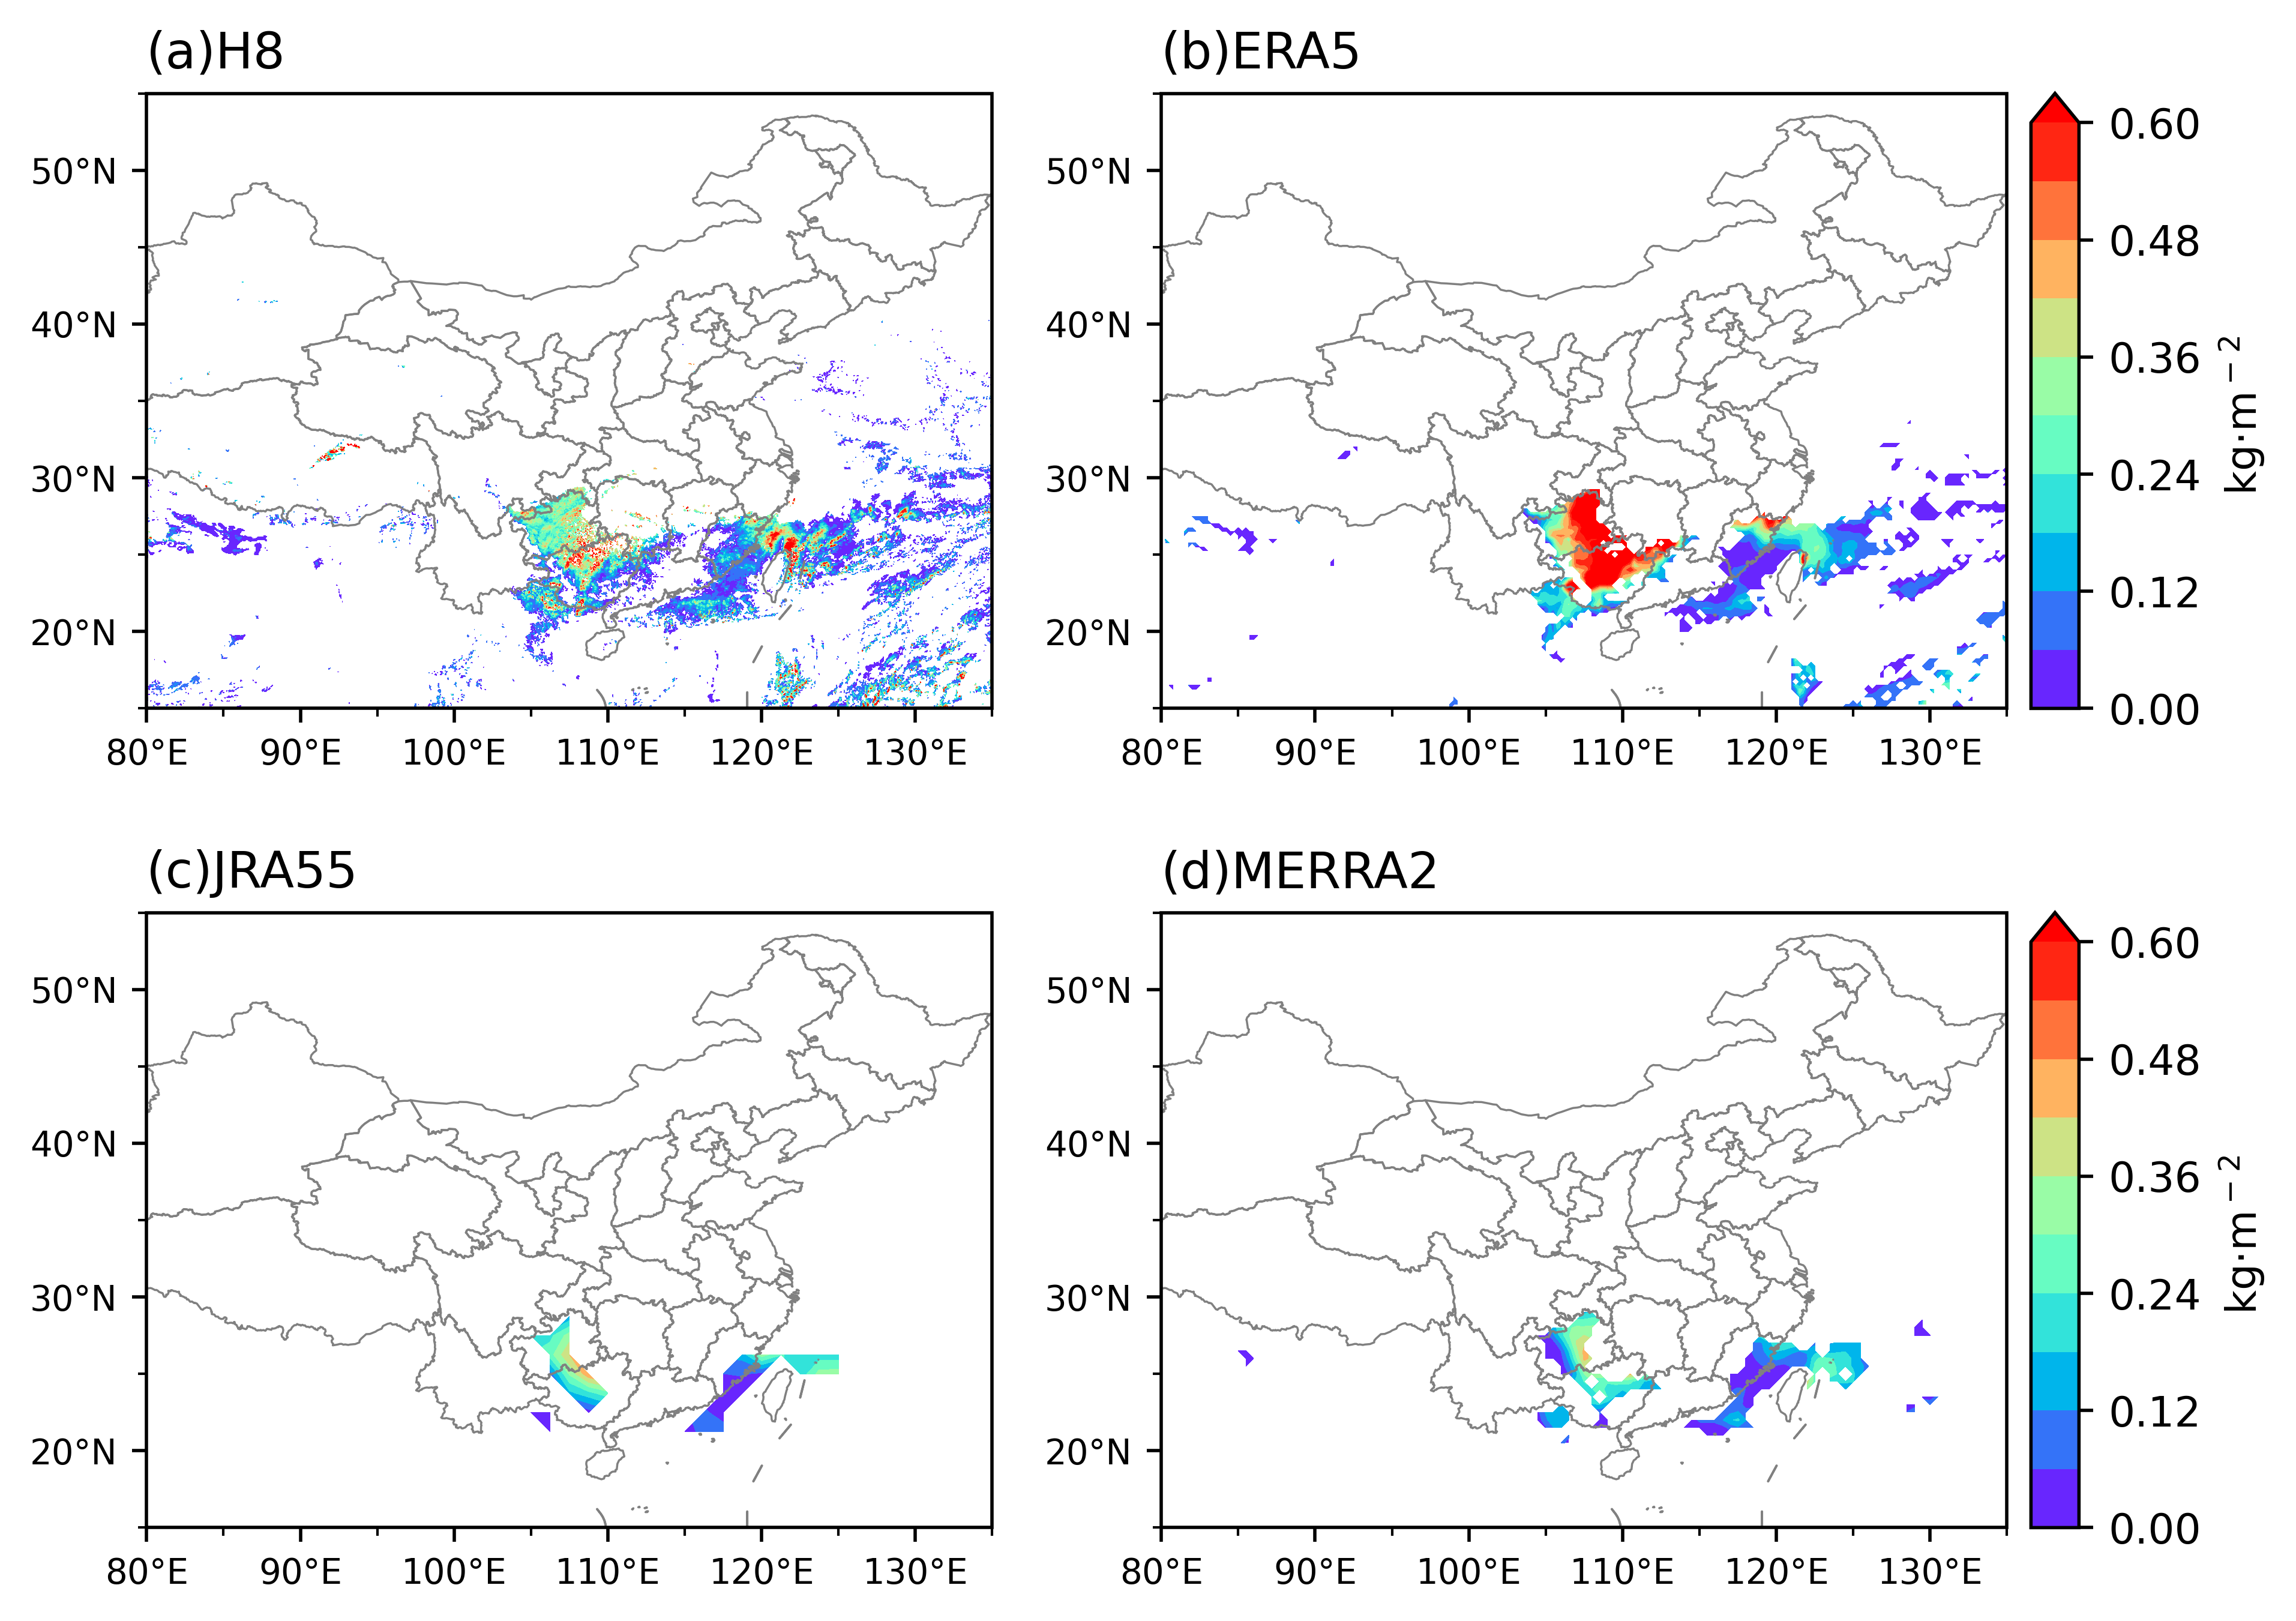

In [ ]:
plt.close()
plot_pic(lwp_CHN, ERA5_CHN_af, JRA55_CHN_af, MERRA2_CHN_af)

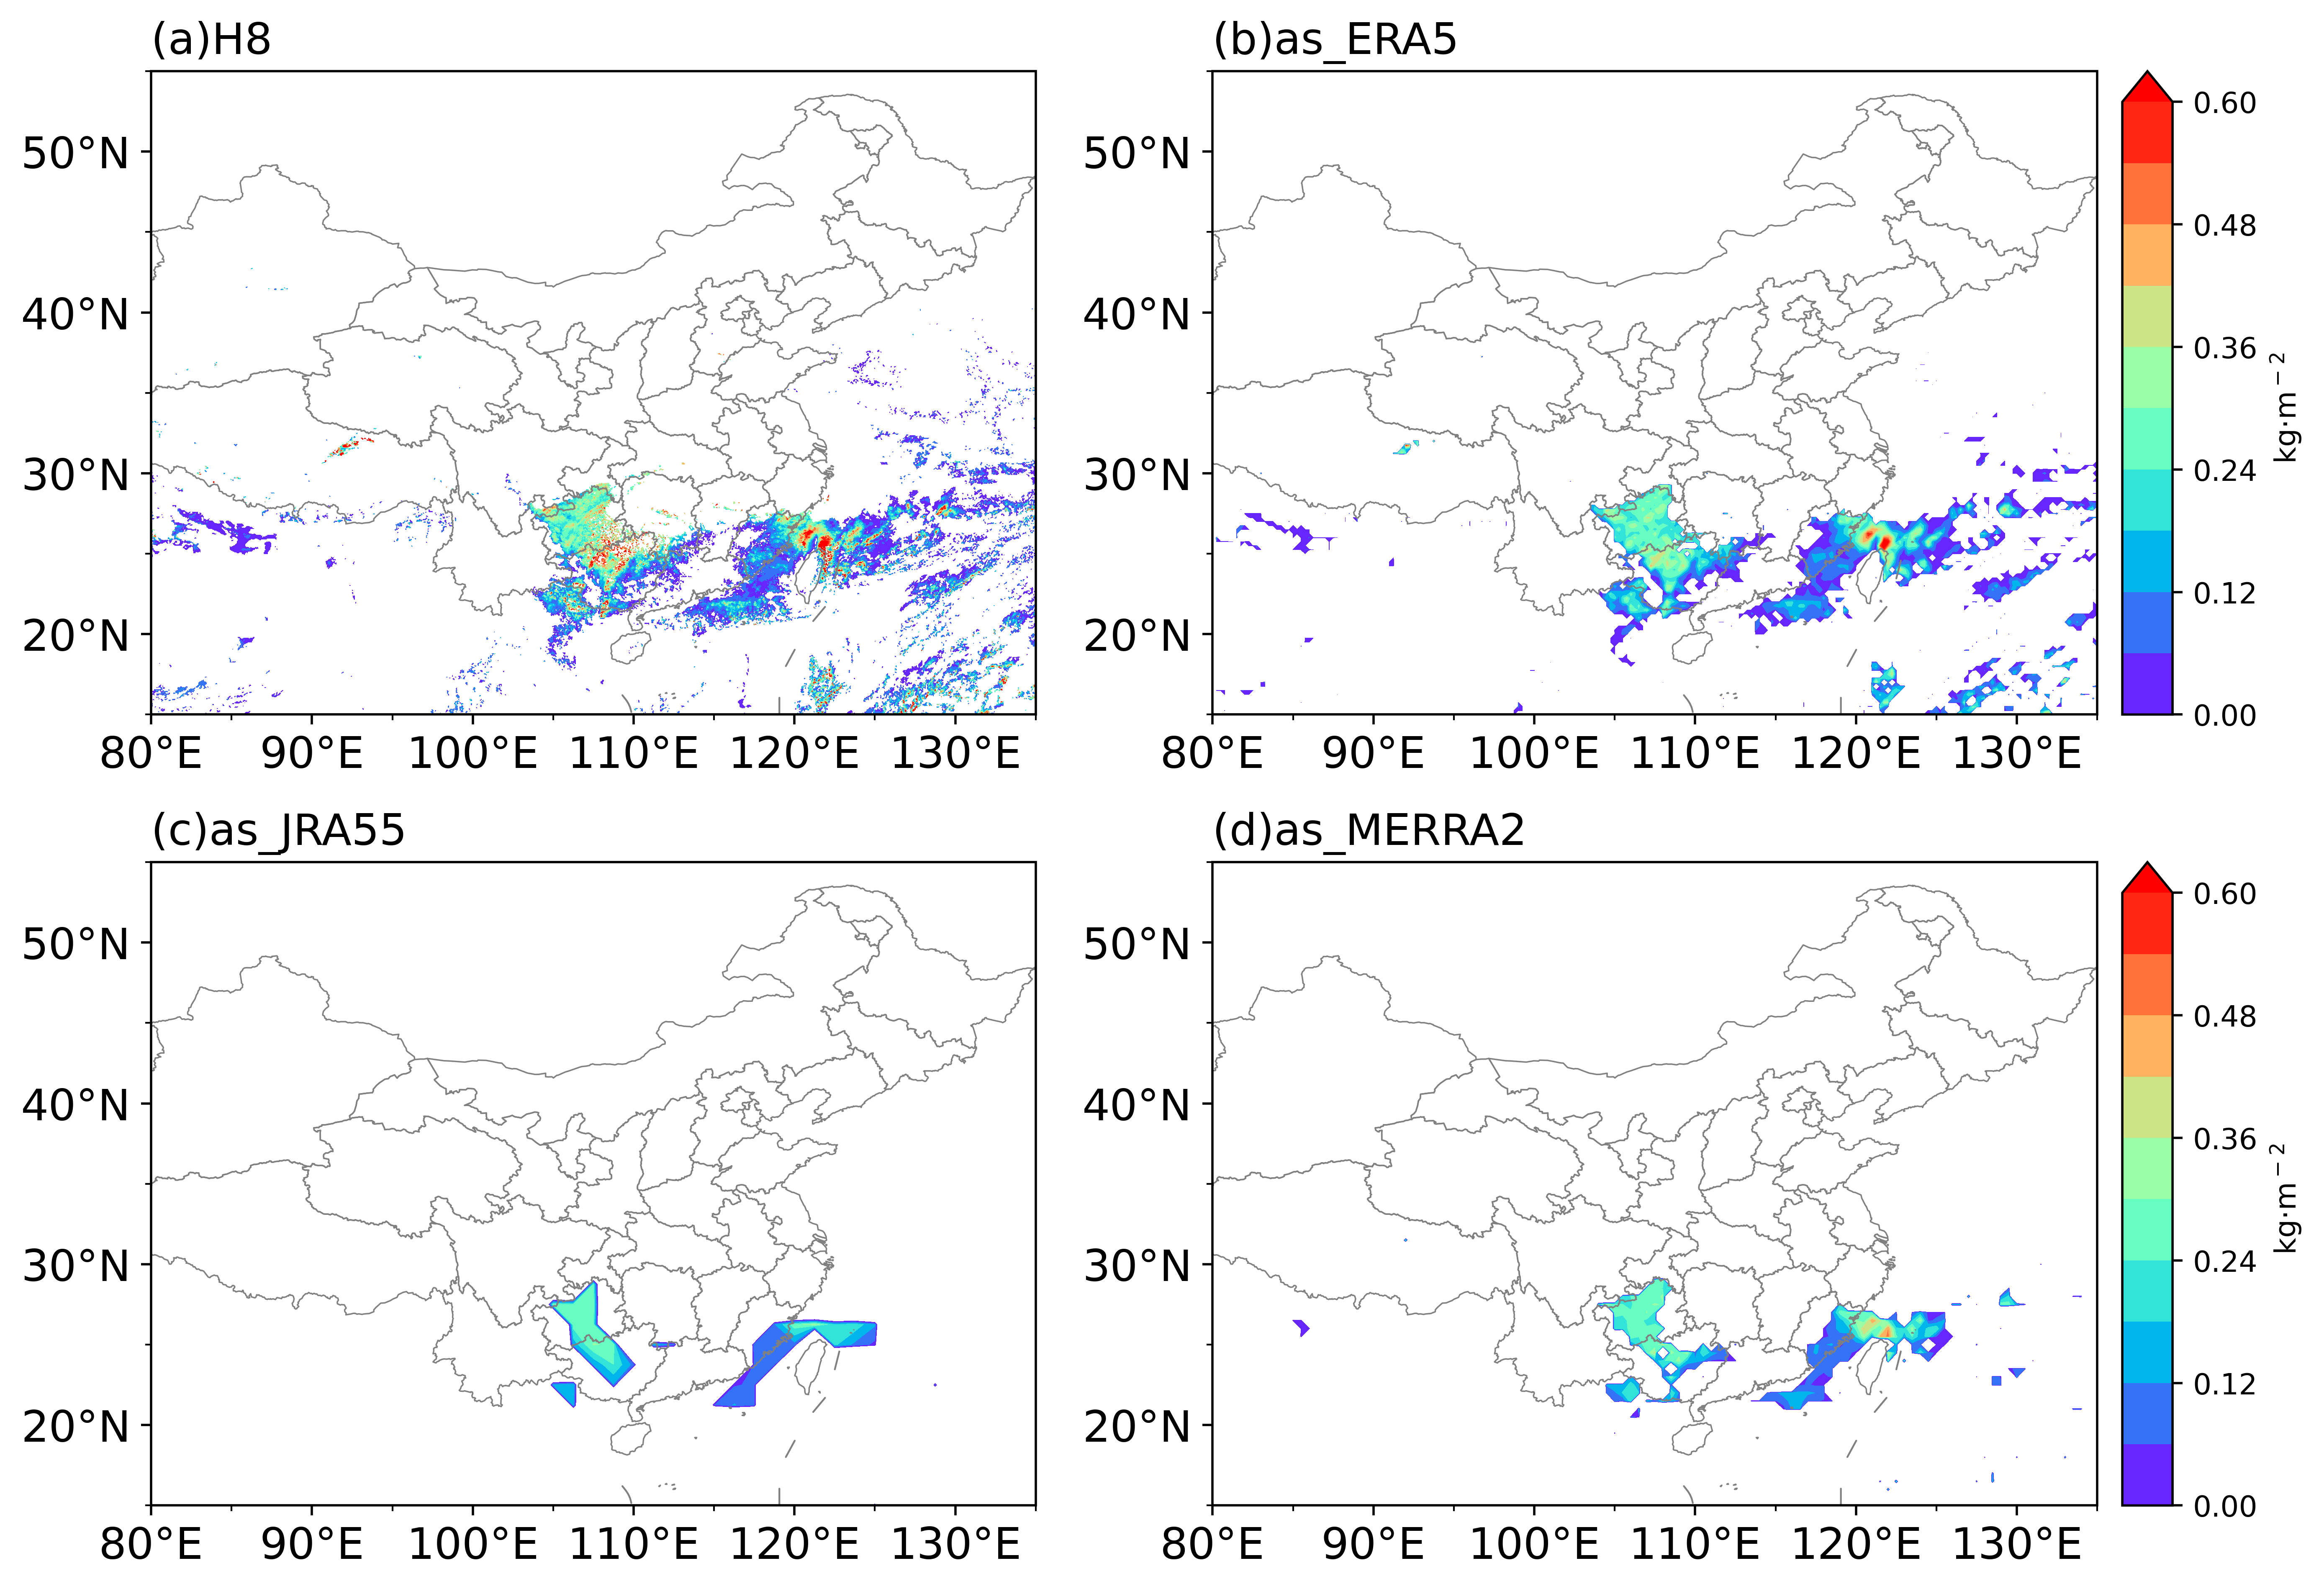

In [ ]:
plt.close()
plot_pic2(lwp_CHN, array_asERA5, array_asJRA55, array_asMERRA2[::-1,:])